In [39]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


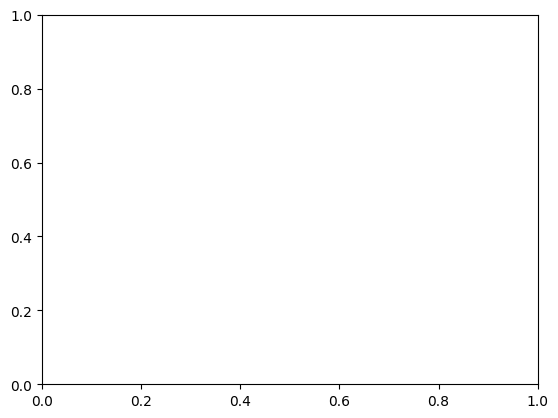

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
fig, ax = plt.subplots(1, 1)


In [2]:
import torch
import cv2
from torch.utils.data.dataset import Dataset  # noqa:E402
from torchvision.io import decode_image  # noqa:E402
from torchvision import transforms  # noqa:E402
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.data import DataLoader
from pathlib import Path  # noqa:E402
from unit_test import TestAssertions, unit_test, run_unit_tests  # noqa:E402
import random
from tqdm import tqdm
from matplotlib import pyplot as plt

In [3]:
SAVE_DIR = Path("checkpoints")
MAX_EPOCH = 100

In [4]:
# Check if cuda device is available
print("CUDA available:", torch.cuda.is_available())
use_cuda = torch.cuda.is_available()


CUDA available: True


In [8]:
!bash download_data.sh

Data downloaded and extracted to data/


In [13]:
# read any image from the data/BSDS300/image/train folder
image_path = Path("data/BSDS300/images/train/2092.jpg")
image = decode_image(str(image_path))
print(image.shape)


torch.Size([3, 321, 481])


In [103]:
from abc import abstractmethod


class ExtractPatch():
    @abstractmethod
    def extract_patches(self, idx, patch_size, stride, batch_size=128):
        pass

class Bsd300(Dataset):
    def __init__(self, data_folder, transform=None):
        self.data_folder = Path(data_folder)
        self.transform = transform
        self.labels = []
        with open(self.data_folder / "iids_train.txt") as f:
            self.labels = f.readlines()
        if len(self.labels) == 0:
            print("No labels found in", data_folder)

        pass

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        label = self.labels[idx]
        img_name = self.data_folder / f"images/train/{label.strip()}.jpg"
        image = decode_image(str(img_name))
        if self.transform:
            image = self.transform(image)
        return image, label

class Train400(Dataset, ExtractPatch):
    def __init__(self, data_folder, transform=None):
        self.data_folder = Path(data_folder)
        self.transform = transform
        # list get file stems in the data_folder/train400 folder
        self.labels = [f.stem for f in self.data_folder.glob("*.png")]
        if len(self.labels) == 0:
            raise FileNotFoundError(f"No images found in {data_folder}")


    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        label = self.labels[idx]
        img_name = self.data_folder / f"{label}.png"
        image = decode_image(str(img_name))
        return image, label
    
    def extract_patches(self, idx, patch_size, stride, batch_size):
        image, label = self.__getitem__(idx)
        patches = []
        for i in range(0, image.shape[1] - patch_size + 1, stride):
            for j in range(0, image.shape[2] - patch_size + 1, stride):
                patch = image[:,i:i+patch_size, j:j+patch_size]
                if self.transform:
                    patch = self.transform(patch)
                patches.append(patch)
        
        n_patches_to_remove_for_batch_normalization = len(patches) % batch_size
        patches = patches[:-n_patches_to_remove_for_batch_normalization]
        patches = torch.stack(patches)
        return patches, label
    
    def read_all_patches(self, patch_size, stride, batch_size=128):
        all_patches = []
        for i in range(len(self)):
            patches, _ = self.extract_patches(i, patch_size, stride, batch_size)
            all_patches.append(patches)
        return torch.cat(all_patches)


class NoisyPatchDataset(Dataset):
    def __init__(self, patches, sigma: float | tuple[float, float]=25):
        self.patches = patches
        self.sigma = sigma
    
    def __len__(self):
        return self.patches.size(0)
    
    def __getitem__(self, idx):
        patches = self.patches[idx]
        if isinstance(self.sigma, tuple): # sigma is a tuple of two floats
            sigma = random.uniform(self.sigma[0], self.sigma[1])
            noisy_patches = patches + torch.randn_like(patches) * sigma / 255.0
        else:
            noisy_patches = patches + torch.randn_like(patches) * self.sigma / 255.0

        return noisy_patches, patches

class Tests:
    @staticmethod
    @unit_test
    def dataset_loading_and_indexing():
        dataset = Bsd300("data/BSDS300")
        TestAssertions.assert_eq(len(dataset), 200, "Dataset should have = 200 images")
        _, _ = dataset[0] 
        dataset = Train400("data/Train400")
        TestAssertions.assert_eq(len(dataset), 400, "Dataset should have = 400 images")
        _, _ = dataset[0]
    
    @staticmethod
    @unit_test
    def dataset_transform_cropping():
        dataset = Bsd300("data/BSDS300", transform=transforms.RandomCrop(180))
        for i in range(len(dataset)):
            image, _ = dataset[i]
            TestAssertions.assert_eq(image.shape[1], 180, "Image H should be cropped to 180")
            TestAssertions.assert_eq(image.shape[2], 180, "Image W should be cropped to 180")
    
    @staticmethod
    @unit_test
    def dataset_transform_patch_cropping():
        transform = transforms.RandomChoice([
            transforms.RandomRotation((90, 90)),
        ])
        dataset = Train400("data/Train400", transform=transform)
        stride = 6
        patches, label = dataset.extract_patches(0, patch_size=40, stride=stride, batch_size=128)
        patch1 = patches[0,:,:,:]

        dataset = Train400("data/Train400")
        stride = 6
        patches, label = dataset.extract_patches(0, patch_size=40, stride=stride, batch_size=128)
        patch2 = patches[0,:,:,:]
        patch2 = torch.rot90(patch2, dims=(1, 2))
        # check if patch1 and patch2 are the same use torch.allclose
        TestAssertions.assert_eq(torch.allclose(patch1, patch2), True, f"Patch 1 and Patch 2 should be the same, {patch1.shape}, {patch2.shape}")
        pass

    @staticmethod
    @unit_test
    def read_all_patches():
        dataset = Train400("data/Train400")
        patches = dataset.read_all_patches(patch_size=40, stride=6)
        print(patches.shape)
        noisy_dataset = NoisyPatchDataset(patches, sigma=(0, 50))
        TestAssertions.assert_eq(len(noisy_dataset), 204800, "Noisy dataset should have 204800 patches")

run_unit_tests(Tests)

Found 4 unit tests
----------------------------------------
Running test: dataset_loading_and_indexing
✓ dataset_loading_and_indexing passed
Running test: dataset_transform_cropping
✓ dataset_transform_cropping passed
Running test: dataset_transform_patch_cropping
✓ dataset_transform_patch_cropping passed
Running test: read_all_patches
torch.Size([204800, 1, 40, 40])
✓ read_all_patches passed
----------------------------------------
Tests run: 4, Passed: 4, Failed: 0


In [57]:
from datetime import datetime
class Logger:
    def __init__(self, folder="logs"):
        self.timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        self.folder = Path(folder)
        self.folder.mkdir(parents=True, exist_ok=True)


    def log(self, **kwargs):
        # create a new file called log_<timestamp>.txt
        with open(self.folder / f"log_{self.timestamp}.txt", "a") as f:
            kwargs["timestamp"] = datetime.now().strftime("%Y%m%d_%H%M%S")
            # write the kwargs to the file
            f.write(str(kwargs))
            f.write("\n")


In [86]:
class DnCNN(nn.Module):
    def __init__(self, num_layers=17, num_channels=64, kernel_size=3, image_channels=1, padding=1):
        super(DnCNN, self).__init__()
        layers = []

        layers.append(nn.Conv2d(in_channels=image_channels, out_channels=num_channels, kernel_size=kernel_size, padding=padding, bias=True))
        layers.append(nn.ReLU(inplace=True))
        for _ in range(num_layers-2):
            layers.append(nn.Conv2d(in_channels=num_channels, out_channels=num_channels, kernel_size=kernel_size, padding=padding, bias=False))
            layers.append(nn.BatchNorm2d(num_channels, eps=0.0001, momentum = 0.95))
            layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Conv2d(in_channels=num_channels, out_channels=image_channels, kernel_size=kernel_size, padding=padding, bias=True))
        self.dncnn = nn.Sequential(*layers)

        # Initialize weights
        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                init.orthogonal_(module.weight)
                if module.bias is not None:
                    init.constant_(module.bias, 0)

    def forward(self, x):
        y = x
        noise = self.dncnn(x)
        return y - noise # cleaned image

def save_checkpoint(model, epoch, save_dir: Path):
    if not save_dir.exists():
        save_dir.mkdir(parents=True)
    torch.save(model.state_dict(), save_dir / f'model_{epoch:03d}.pth')

def load_checkpoint(model, save_dir):
    checkpoints = list(save_dir.glob('model_*.pth'))
    if len(checkpoints) == 0:
        print("No checkpoints found, train from beginning")
        return
    # sort the checkpoints by the epoch number
    checkpoints = sorted(checkpoints, key=lambda x: int(x.stem.split('_')[-1]), reverse=True)

    # get the latest checkpoint
    latest_checkpoint = checkpoints[0]
    model.load_state_dict(torch.load(latest_checkpoint))
    print(f"Loaded checkpoint from {latest_checkpoint}")
    return True

In [104]:
model = DnCNN()
load_checkpoint(model, SAVE_DIR)
model.train()
if use_cuda:
    model = model.cuda()


criterion = nn.MSELoss(reduction = 'sum') 
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = MultiStepLR(optimizer, milestones=[30, 60, 90], gamma=0.2)  # learning rates

transform = transforms.RandomChoice([
    transforms.RandomRotation((-90, -90)),
    transforms.RandomRotation((-180, -180)),
    transforms.RandomRotation((-270, -270)),

    transforms.RandomVerticalFlip(1),
    transforms.Compose([
        transforms.RandomRotation((-90, -90)),
        transforms.RandomVerticalFlip(1),
    ]),

    transforms.Compose([
        transforms.RandomRotation((-180, -180)),
        transforms.RandomVerticalFlip(1),
    ]),

    transforms.Compose([
        transforms.RandomRotation((-270, -270)),
        transforms.RandomVerticalFlip(1),
    ]),
])

logger = Logger()

for epoch in range(MAX_EPOCH):
    training_dataset = Train400("data/Train400", transform=transform)
    patches = training_dataset.read_all_patches(patch_size=40, stride=6, batch_size=128)
    # convert patches to float32 and normalize to [0, 1]
    patches = patches.to(torch.float32) / 255.0
    noisy_dataset = NoisyPatchDataset(patches, sigma=25)

    dataloader = DataLoader(noisy_dataset, batch_size=128, shuffle=True)
    epoch_loss = 0

    # Create progress bar for batches within this epoch
    pbar = tqdm(dataloader, desc=f'Epoch {epoch+1}/{MAX_EPOCH}', leave=False)
    # xs = datagenerator(data_dir="data/Train400")
    # xs = xs.astype('float32')/255.0
    # xs = torch.from_numpy(xs.transpose((0, 3, 1, 2)))  # tensor of the clean patches, NXCXHXW
    # DDataset = DenoisingDataset(xs, 25)
    # DLoader = DataLoader(dataset=DDataset, num_workers=4, drop_last=True, batch_size=128, shuffle=True)
    
    # pbar = tqdm(DLoader, desc=f'Epoch {epoch+1}/{MAX_EPOCH}', leave=False)
    for n_count, (noisy_patches, patches) in enumerate(pbar):
    # for n_count, batch_yx in enumerate(pbar):
        optimizer.zero_grad()
        if use_cuda:
            noisy_patches = noisy_patches.cuda()
            patches = patches.cuda()

        output = model(noisy_patches) # learned noise
        target = patches
        loss = criterion(output, target)
        # if use_cuda:
        #     batch_x, batch_y = batch_yx[1].cuda(), batch_yx[0].cuda()

        # loss = criterion(model(batch_y), batch_x)
        epoch_loss += loss.item()

        loss.backward()
        optimizer.step()
        
        # Update progress bar with current loss
        avg_loss = epoch_loss / (n_count + 1)
        pbar.set_postfix({'Loss': f'{loss.item():.4f}', 'Avg Loss': f'{avg_loss:.4f}'})
        if n_count % 128 == 0:
            logger.log(epoch=epoch, batch_idx=n_count, loss=loss.item(), avg_loss=avg_loss)

    scheduler.step()
    save_checkpoint(model, epoch+1, SAVE_DIR)


No checkpoints found, train from beginning


KeyboardInterrupt: 

In [105]:
# load the latest checkpoint
model = DnCNN()
load_checkpoint(model, SAVE_DIR)


Loaded checkpoint from checkpoints/model_005.pth


True

In [106]:
model.eval()
model.cuda();

In [81]:

# transform to grayscale
transform = transforms.Compose([
    transforms.CenterCrop((40, 40))
])

# Load test dataset
test_dataset = Train400("data/Train400", transform=transform)
image, label = test_dataset[0]
image = image.to(torch.float32) / 255.0

In [41]:
print(image)

tensor([[[0.3804, 0.3725, 0.2980,  ..., 0.0667, 0.1333, 0.2235],
         [0.4510, 0.3176, 0.2235,  ..., 0.0510, 0.0667, 0.1098],
         [0.3373, 0.2353, 0.1529,  ..., 0.0588, 0.0471, 0.0745],
         ...,
         [0.1137, 0.1255, 0.1098,  ..., 0.1843, 0.1922, 0.2941],
         [0.1451, 0.0980, 0.0941,  ..., 0.1725, 0.1804, 0.1804],
         [0.1373, 0.1137, 0.0745,  ..., 0.1608, 0.1804, 0.1373]]])


Original image shape: torch.Size([1, 180, 180])
Original image range: [0.000, 1.000]
Denoised image range: [0.015, 1.000]


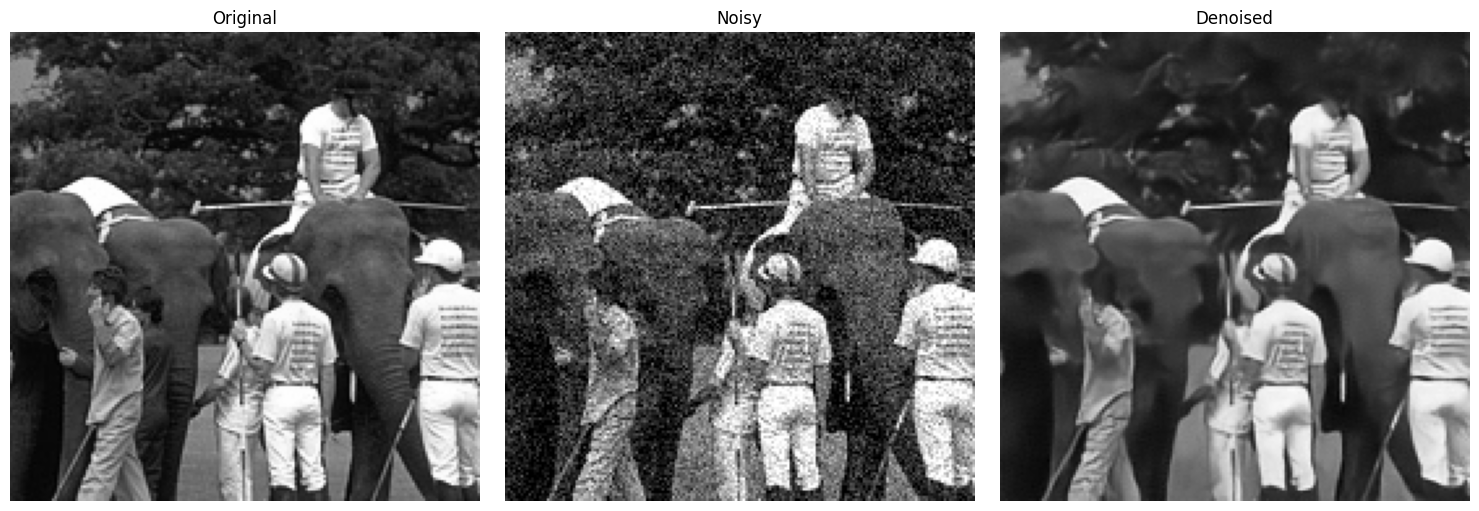

In [107]:

print(f"Original image shape: {image.shape}")
print(f"Original image range: [{image.min():.3f}, {image.max():.3f}]")

# Convert to float32 and normalize to [0,1] first
noisy_image = image + torch.randn_like(image) * 25/255.0

# Clamp to valid range
noisy_image = torch.clamp(noisy_image, 0, 1)

# Prepare for model inference
noisy_image = noisy_image.unsqueeze(0).cuda()

# Set model to evaluation mode
model.eval()

# Denoise the image
with torch.no_grad():  # Disable gradients for inference
    denoised_image = model(noisy_image)

    
    # Clamp the result to valid range
    denoised_image = torch.clamp(denoised_image, 0, 1)

# Convert back to numpy for visualization
denoised_image = denoised_image.squeeze().detach().cpu().numpy()
noisy_image_np = noisy_image.squeeze().detach().cpu().numpy()
original_image_np = image.squeeze().numpy()

print(f"Denoised image range: [{denoised_image.min():.3f}, {denoised_image.max():.3f}]")

# Plot comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(original_image_np, cmap='gray', vmin=0, vmax=1)
axes[0].set_title('Original')
axes[0].axis('off')

axes[1].imshow(noisy_image_np, cmap='gray', vmin=0, vmax=1)
axes[1].set_title('Noisy')
axes[1].axis('off')

axes[2].imshow(denoised_image, cmap='gray', vmin=0, vmax=1)
axes[2].set_title('Denoised')
axes[2].axis('off')

plt.tight_layout()
plt.show()










(180, 180)
torch.Size([1, 1, 180, 180])


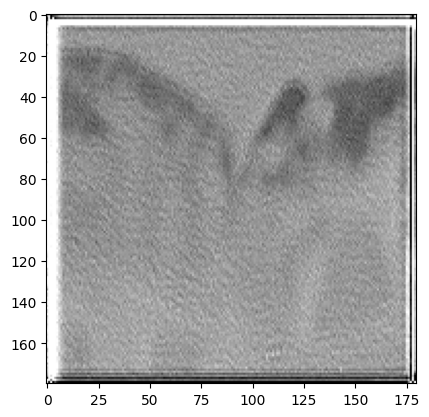

In [71]:
from cv2 import imread
x = np.array(imread(Path("data/Train400/test_001.png"), 0), dtype=np.float32)/255.0
np.random.seed(seed=0)  # for reproducibility
print(x.shape)
y = x + np.random.normal(0, 25/255.0, x.shape)  # Add Gaussian noise without clipping
y = y.astype(np.float32)
y_ = torch.from_numpy(y).view(1, -1, y.shape[0], y.shape[1])

y_ = y_.cuda()
print(y_.shape)
x_ = model(y_)  # inference
x_ = x_.view(y.shape[0], y.shape[1])
x_ = x_.cpu()
x_ = x_.detach().numpy().astype(np.float32)

plt.figure(figsize=(10, 10))
plt.imshow(x_, cmap='gray', vmin=0, vmax=1)
plt.show()